In [2]:
import warnings; warnings.filterwarnings("ignore")
import os;
from sys import platform
print(os.getcwd())
if platform == "darwin":
    os.chdir('/Users/ziyingc/Dropbox/Lab/MotorCortex')
elif platform == "win32":
    os.chdir('D:\Dropbox\Lab\MotorCortex')
print(os.getcwd())
import numpy as np
import comparison as cmp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm; 
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pycwt as wavelet; mother = wavelet.Morlet(6)
from scipy import stats
import read_data as rd;   import time2frequency as t2f
import behavior_track as bt ; import behavior_plot as bp ;
import philters
fps = 30; fs_out = 1000; fs = 30000; T = 1/fs_out;
N = int((1/fps)/T/2+1);

sgn   = ['***','**','*']
P_sgn = np.array([0.0001, 0.001, 0.05])

/Users/ziyingc/Dropbox/Lab/MotorCortex/Multi_Rats_ver2.0
/Users/ziyingc/Dropbox/Lab/MotorCortex


In [3]:
mode = 'FFT'
f = np.load('Rats/freqs_'+mode+'_'+str(fs_out)+'.npy');x_fit = np.log10(f); 
T_pre = 0


idx_band = np.load('Rats/idx_band.npy')
f_band = f[idx_band]
l_fb = len(f_band)

T1 = np.load('Rats/T1.npy');
T2 = np.load('Rats/T2.npy');

t = np.arange(T_pre+T2).astype('int')/fps;
power_c = ['r','b','k']
MI_c = ['orange','green']

idx_bt_1 = np.load('Rats/idx_bt_1.npy')
idx_bt_2 = np.load('Rats/idx_bt_2.npy')
idx_bf_b = np.load('Rats/idx_bf_b.npy')
idx_bf_l = np.load('Rats/idx_bf_l.npy');
idx_bf_h = np.load('Rats/idx_bf_h.npy');

# idx_bf_l = np.logical_and(f_band>=20.00, f_band<=30.00);
# idx_bf_h = np.logical_and(f_band>=31.25, f_band<=41.25);
# idx_bt_1 = np.arange(T_pre+60,    T_pre+60+30).astype('int');
# idx_bt_2 = np.arange(T_pre+T1-10, T_pre+T1+20).astype('int');

print('T1:', T1, 'T2:', T2, idx_bt_1[0], idx_bt_1[-1], idx_bt_2[0], idx_bt_2[-1])
f_beta_b = f_band[idx_bf_b];
f_beta_l = f_band[idx_bf_l]; f_win_l = np.hanning(len(f_beta_l))
f_beta_h = f_band[idx_bf_h]; f_win_h = np.hanning(len(f_beta_h))

print(f_beta_b[0], f_beta_b[-1], f_beta_l[0], f_beta_l[-1], f_beta_h[0], f_beta_h[-1], idx_bt_1[[0,-1]], idx_bt_2[[0,-1]])

T1: 90 T2: 120 10 54 70 114
13.75 22.5 23.75 32.5 33.75 42.5 [10 54] [ 70 114]


# Lesion

_post
ws_Rats/Rat_Outlaw 1
1 1
ws_Rats/Rat_Drifter 1
1 2
ws_Rats/Rat_Lenny 1
1 3


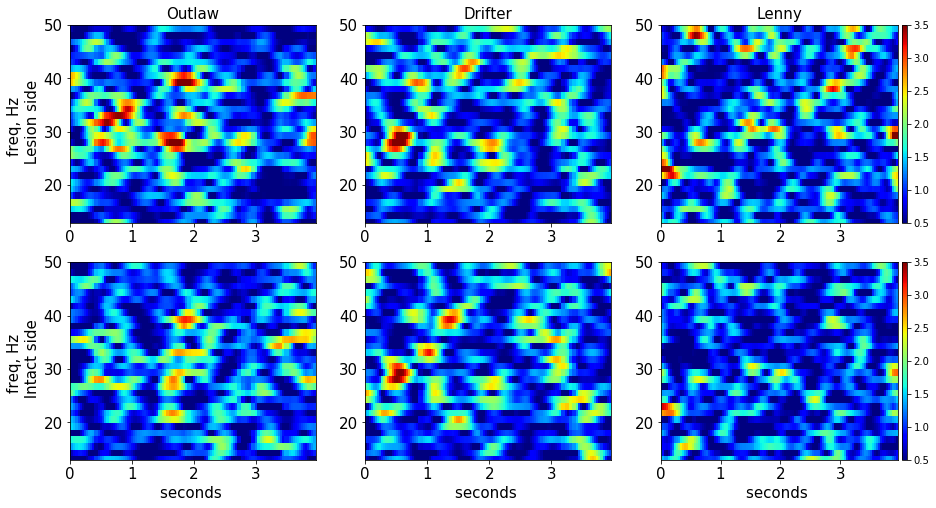

In [4]:
rats = '_post'
# rats = '_pre'
print(rats)
# erfdn = np.load('Rats/Rats_ephy'+rats+'.npy')[[1,2,4]];

erfdn = np.load('Rats/Screws_Rats/Rats/Rats_ephy'+rats+'.npy')[[1,2,4]]
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))
fig.set_figheight(8); fig.set_figwidth(n_r*5)
gs  = GridSpec(2 , n_r);

rr = 0
n_acc_total_r = 0
for rfdn in erfdn:
    
    epn       = np.load(rfdn+'tracking'+'/epn_ephy'+rats+'.npy')[[2]]
    slope     = np.load(rfdn+'tracking'+'/slope_epn_ephy'+rats+'.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_ephy'+rats+'.npy')

    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)
    
    idx_k   = np.zeros((n_k,))>1
    
    Y_acc_l = np.zeros((l_fb, T2+T_pre));
    Y_acc_i = np.zeros((l_fb, T2+T_pre));
    y_acc_i_all = np.zeros((l_fb, ));
    Y_acc_l_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_h = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_h = np.empty((0, T2+T_pre))
    
    spd_f_ac = np.empty((0, T2+T_pre))
    n_acc_total = 0
    kk = 0
    lag_m       = np.load(rfdn+'tracking/lag_m.npy')
    idx_acc_f_T = np.load(rfdn+'tracking/idx_acc_f_T.npy')
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 10
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean     = np.logical_and(idx_clean_f, idx_clean_fft)
        
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        T_ts = len(ts_f[idx_clean])/fps/60

        i_ref = 0;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_l = (Y_f/y_fit)[:,idx_band]

        i_ref = 1;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_i = (Y_f/y_fit)[:,idx_band]

        idx_acc_f   = np.load(fdn+'tracking/idx_acc_f.npy')[[0]];
        T_acc_f   = np.load(fdn+'tracking/T_acc_f.npy')[[0]];
        idx_acc_f_k = np.load(fdn+'tracking/idx_acc_f_k.npy')[[0]];
        
        n_acc = len(idx_acc_f)
        if n_acc>0:
            lag   = lag_m[idx_acc_f_k];
            idx_acc_f_T_k = idx_acc_f_T[idx_acc_f_k];
            lag       = lag[idx_acc_f_T_k]
            T_acc_f   = T_acc_f[idx_acc_f_T_k]
            idx_acc_f = idx_acc_f[idx_acc_f_T_k]
            n_acc = len(idx_acc_f)
            n_acc_total = n_acc_total+n_acc
            if n_acc>0:
                idx_acc_f = idx_acc_f+T_acc_f-lag
                for i in np.arange(len(idx_acc_f)):
                    t_ref = idx_acc_f[i]
                    idx_t_spec = np.arange(t_ref-T_pre,t_ref+T2).astype('int')

                    y_acc_l = Y_f_fit_l[idx_t_spec,:].T;  Y_acc_l = Y_acc_l + y_acc_l
                    y_acc_l_m_bf_b = np.mean(y_acc_l[idx_bf_b,:], axis=0);
                    y_acc_l_m_bf_l = np.mean(y_acc_l[idx_bf_l,:], axis=0);
                    y_acc_l_m_bf_h = np.mean(y_acc_l[idx_bf_h,:], axis=0);
                    Y_acc_l_m_bf_b = np.vstack((Y_acc_l_m_bf_b, y_acc_l_m_bf_b))
                    Y_acc_l_m_bf_l = np.vstack((Y_acc_l_m_bf_l, y_acc_l_m_bf_l))
                    Y_acc_l_m_bf_h = np.vstack((Y_acc_l_m_bf_h, y_acc_l_m_bf_h))

                    y_acc_i = Y_f_fit_i[idx_t_spec,:].T;  Y_acc_i = Y_acc_i + y_acc_i
                    y_acc_i_m_bf_b = np.mean(y_acc_i[idx_bf_b,:], axis=0);
                    y_acc_i_m_bf_l = np.mean(y_acc_i[idx_bf_l,:], axis=0);
                    y_acc_i_m_bf_h = np.mean(y_acc_i[idx_bf_h,:], axis=0);
                    Y_acc_i_m_bf_b = np.vstack((Y_acc_i_m_bf_b, y_acc_i_m_bf_b))
                    Y_acc_i_m_bf_l = np.vstack((Y_acc_i_m_bf_l, y_acc_i_m_bf_l))
                    Y_acc_i_m_bf_h = np.vstack((Y_acc_i_m_bf_h, y_acc_i_m_bf_h))
                    
                    spd_f_ac = np.vstack((spd_f_ac,spd_f[idx_t_spec]))

        kk += 1
    Y_acc_l_m = Y_acc_l/n_acc_total
    ax_idx = gs[0,rr]; ax = fig.add_subplot(ax_idx);
    im = ax.pcolormesh(t, f_band, Y_acc_l_m, 
                               vmin = 0.5,
                               vmax = 3.5,
                       cmap=cm.jet);
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05); fig.colorbar(im, cax=cax);
    ax.set_ylim([13,50])
    
    
    ax.set_title(rfdn[21:len(rfdn)-1], fontsize=15);
    
    ax.tick_params(labelsize=15);
    Y_acc_i_m = Y_acc_i/n_acc_total
    ax_idx = gs[1,rr]; ax = fig.add_subplot(ax_idx);
    im = ax.pcolormesh(t, f_band, Y_acc_i_m, 
                               vmin = 0.5,
                               vmax = 3.5,
                       cmap=cm.jet);
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05);fig.colorbar(im, cax=cax);
    ax.set_ylim([13,50])
    
    ax.tick_params(labelsize=15);
    ax.set_xlabel('seconds ',  fontsize = 15)
    
    n_acc_total_r = n_acc_total_r+n_acc_total
    print(n_acc_total, n_acc_total_r)
    rr += 1
    
ax_idx = gs[0,rr-1]; ax = fig.add_subplot(ax_idx);   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05);fig.colorbar(im, cax=cax);
ax_idx = gs[1,rr-1]; ax = fig.add_subplot(ax_idx);   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05);fig.colorbar(im, cax=cax);

ax_idx = gs[0,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('freq, Hz \n Lesion side', fontsize = 15)
ax_idx = gs[1,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('freq, Hz \n Intact side', fontsize = 15)

plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_MI_spectrogram.pdf')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_MI_spectrogram.eps')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_MI_spectrogram.png')



_post
ws_Rats/Rat_Outlaw 42
74 74
ws_Rats/Rat_Drifter 15
62 136
ws_Rats/Rat_Lenny 8
37 173


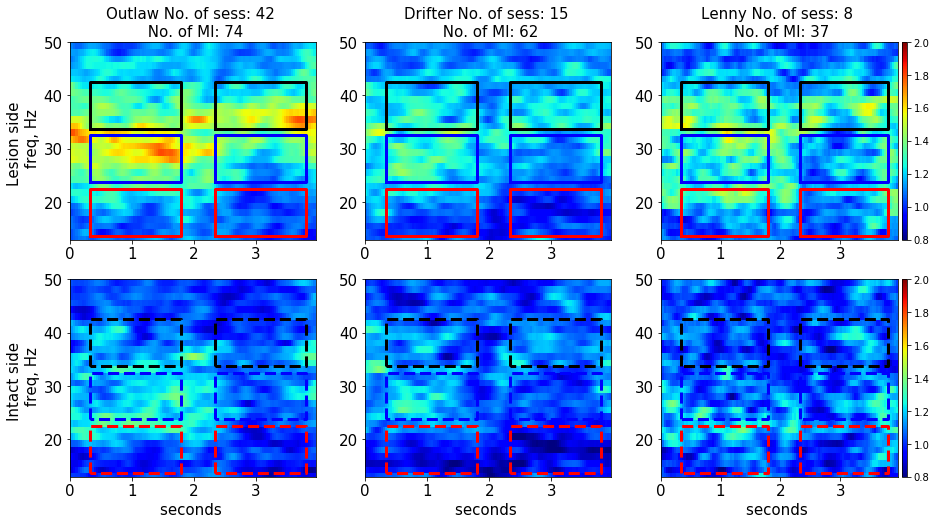

In [5]:
rats = '_post'
# rats = '_pre'
print(rats)

# erfdn = np.load('Rats/Rats_ephy'+rats+'.npy')[[1,2,4]];
erfdn = np.load('Rats/Screws_Rats/Rats/Rats_ephy'+rats+'.npy')[[1,2,4]]
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))
fig.set_figheight(8); fig.set_figwidth(n_r*5)
gs  = GridSpec(2 , n_r);
rr = 0
n_acc_total_r = 0
for rfdn in erfdn:
    
    epn       = np.load(rfdn+'tracking'+'/epn_ephy'+rats+'.npy')#[[3]]
    slope     = np.load(rfdn+'tracking'+'/slope_epn_ephy'+rats+'.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_ephy'+rats+'.npy')

    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)
    
    idx_k   = np.zeros((n_k,))>1
    
    Y_acc_l = np.zeros((l_fb, T2+T_pre));
    Y_acc_i = np.zeros((l_fb, T2+T_pre));
    y_acc_i_all = np.zeros((l_fb, ));
    Y_acc_l_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_h = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_h = np.empty((0, T2+T_pre))
    
    spd_f_ac = np.empty((0, T2+T_pre))
    n_acc_total = 0
    kk = 0
    lag_m       = np.load(rfdn+'tracking/lag_m.npy')
    idx_acc_f_T = np.load(rfdn+'tracking/idx_acc_f_T.npy')
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 10
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean     = np.logical_and(idx_clean_f, idx_clean_fft)
        
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        T_ts = len(ts_f[idx_clean])/fps/60

        i_ref = 0;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_l = (Y_f/y_fit)[:,idx_band]

        i_ref = 1;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_i = (Y_f/y_fit)[:,idx_band]

        idx_acc_f   = np.load(fdn+'tracking/idx_acc_f.npy')#[[0]];
        T_acc_f   = np.load(fdn+'tracking/T_acc_f.npy')#[[0]];
        idx_acc_f_k = np.load(fdn+'tracking/idx_acc_f_k.npy')#[[0]];
        
        n_acc = len(idx_acc_f)
        if n_acc>0:
            lag   = lag_m[idx_acc_f_k];
            idx_acc_f_T_k = idx_acc_f_T[idx_acc_f_k];
            lag       = lag[idx_acc_f_T_k]
            T_acc_f   = T_acc_f[idx_acc_f_T_k]
            idx_acc_f = idx_acc_f[idx_acc_f_T_k]
            n_acc = len(idx_acc_f)
            n_acc_total = n_acc_total+n_acc
            if n_acc>0:
                idx_acc_f = idx_acc_f+T_acc_f-lag
                for i in np.arange(len(idx_acc_f)):
                    t_ref = idx_acc_f[i]
                    idx_t_spec = np.arange(t_ref-T_pre,t_ref+T2).astype('int')

                    y_acc_l = Y_f_fit_l[idx_t_spec,:].T;  Y_acc_l = Y_acc_l + y_acc_l
                    y_acc_l_m_bf_b = np.mean(y_acc_l[idx_bf_b,:], axis=0);
                    y_acc_l_m_bf_l = np.mean(y_acc_l[idx_bf_l,:], axis=0);
                    y_acc_l_m_bf_h = np.mean(y_acc_l[idx_bf_h,:], axis=0);
                    Y_acc_l_m_bf_b = np.vstack((Y_acc_l_m_bf_b, y_acc_l_m_bf_b))
                    Y_acc_l_m_bf_l = np.vstack((Y_acc_l_m_bf_l, y_acc_l_m_bf_l))
                    Y_acc_l_m_bf_h = np.vstack((Y_acc_l_m_bf_h, y_acc_l_m_bf_h))

                    y_acc_i = Y_f_fit_i[idx_t_spec,:].T;  Y_acc_i = Y_acc_i + y_acc_i
                    y_acc_i_m_bf_b = np.mean(y_acc_i[idx_bf_b,:], axis=0);
                    y_acc_i_m_bf_l = np.mean(y_acc_i[idx_bf_l,:], axis=0);
                    y_acc_i_m_bf_h = np.mean(y_acc_i[idx_bf_h,:], axis=0);
                    Y_acc_i_m_bf_b = np.vstack((Y_acc_i_m_bf_b, y_acc_i_m_bf_b))
                    Y_acc_i_m_bf_l = np.vstack((Y_acc_i_m_bf_l, y_acc_i_m_bf_l))
                    Y_acc_i_m_bf_h = np.vstack((Y_acc_i_m_bf_h, y_acc_i_m_bf_h))
                    
                    spd_f_ac = np.vstack((spd_f_ac,spd_f[idx_t_spec]))

        kk += 1
    Y_acc_l_m = Y_acc_l/n_acc_total
    ax_idx = gs[0,rr]; ax = fig.add_subplot(ax_idx);
    im = ax.pcolormesh(t, f_band, Y_acc_l_m, 
                               vmin = 0.7,
                               vmax = 2.0,
                       cmap=cm.jet);ax.set_ylim([13,50])
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05); fig.colorbar(im, cax=cax);ax.set_ylim([13,50])
    
    
    ax.set_title(rfdn[21:len(rfdn)-1] + ' No. of sess: '+str(n_k) +' \n No. of MI: '+str(n_acc_total), fontsize=15);
    
    ax.tick_params(labelsize=15);
    t1 = t[idx_bt_1[0]];  t2 = t[idx_bt_1[-1]];
    fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[0], lw=3)
    fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[1], lw=3)
    fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[2], lw=3)
    
    t1 = t[idx_bt_2[0]];  t2 = t[idx_bt_2[-1]];
    fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[0], lw=3)
    fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[1], lw=3)
    fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[2], lw=3) 
    Y_acc_i_m = Y_acc_i/n_acc_total
    ax_idx = gs[1,rr]; ax = fig.add_subplot(ax_idx);
    im = ax.pcolormesh(t, f_band, Y_acc_i_m, 
                               vmin = 0.8,
                               vmax = 2.0,
                       cmap=cm.jet);ax.set_ylim([13,50])
    
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05);fig.colorbar(im, cax=cax);ax.set_ylim([13,50])
    
    ax.tick_params(labelsize=15);
    t1 = t[idx_bt_1[0]];  t2 = t[idx_bt_1[-1]];
    fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[0], lw=3)
    fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[1], lw=3)
    fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[2], lw=3)
    
    t1 = t[idx_bt_2[0]];  t2 = t[idx_bt_2[-1]];
    fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[0], lw=3)
    fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[1], lw=3)
    fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
    ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[2], lw=3) 
    

    ax.set_xlabel('seconds ',  fontsize = 15)
    
    n_acc_total_r = n_acc_total_r+n_acc_total
    print(n_acc_total, n_acc_total_r)
    rr += 1
ax_idx = gs[0,rr-1]; ax = fig.add_subplot(ax_idx);   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05);fig.colorbar(im, cax=cax);
ax_idx = gs[1,rr-1]; ax = fig.add_subplot(ax_idx);   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05);fig.colorbar(im, cax=cax);

ax_idx = gs[0,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('Lesion side \n freq, Hz', fontsize = 15)
ax_idx = gs[1,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('Intact side \n freq, Hz', fontsize = 15)

plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/Average_MI_spectrogram'+rats+'.pdf')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/Average_MI_spectrogram'+rats+'.eps')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/Average_MI_spectrogram'+rats+'.png')



_post
Outlaw 42
74 74
Drifter 15
62 136
Lenny 8
37 173


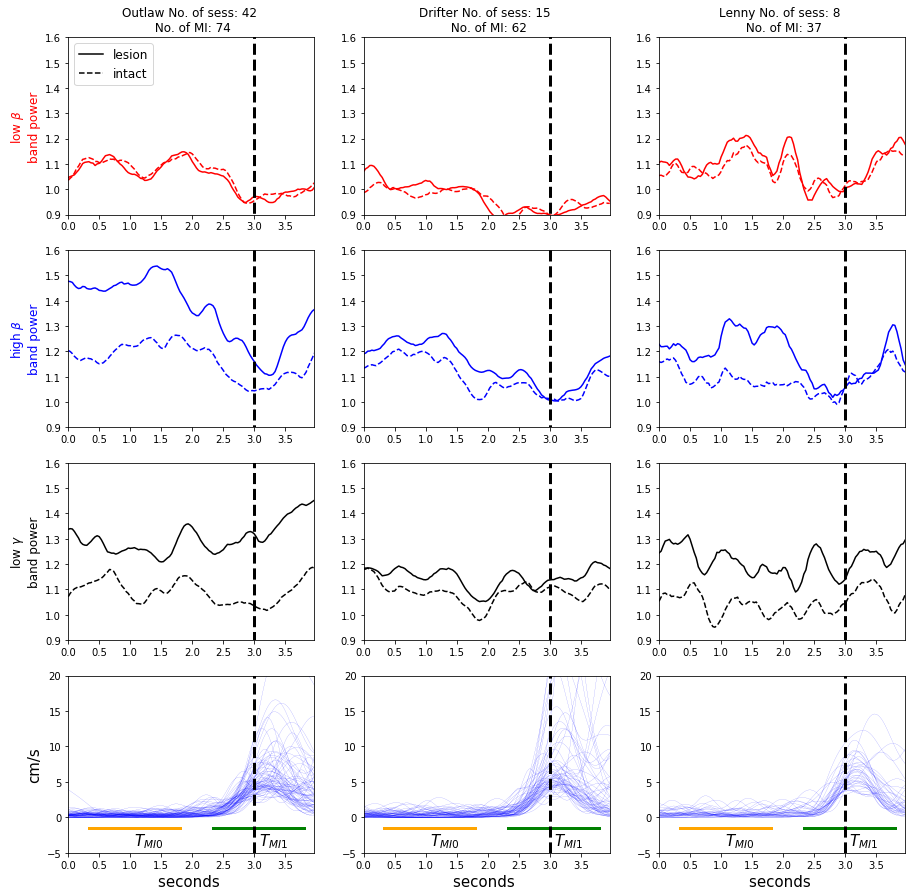

In [57]:
rats = '_post'
# rats = '_pre'
print(rats)
erfdn = np.load('Rats/Rats_ephy'+rats+'.npy')[[1,2,4]];
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))
# fig.set_figheight(20); fig.set_figwidth(n_r*5)
fig.set_figheight(15); fig.set_figwidth(n_r*5)
gs  = GridSpec(4 , n_r);

rr = 0
n_acc_total_r = 0
for rfdn in erfdn:
    
    epn       = np.load(rfdn+'tracking'+'/epn_ephy'+rats+'.npy')#[[21]]
    slope     = np.load(rfdn+'tracking'+'/slope_epn_ephy'+rats+'.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_ephy'+rats+'.npy')

    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)
    
    idx_k   = np.zeros((n_k,))>1
    
    Y_acc_l = np.zeros((l_fb, T2+T_pre));
    Y_acc_i = np.zeros((l_fb, T2+T_pre));
    y_acc_i_all = np.zeros((l_fb, ));
    Y_acc_l_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_h = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_h = np.empty((0, T2+T_pre))
    
    spd_f_ac = np.empty((0, T2+T_pre))
    n_acc_total = 0
    kk = 0
    lag_m       = np.load(rfdn+'tracking/lag_m.npy')
    idx_acc_f_T = np.load(rfdn+'tracking/idx_acc_f_T.npy')
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 10
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean     = np.logical_and(idx_clean_f, idx_clean_fft)
        
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        T_ts = len(ts_f[idx_clean])/fps/60

        i_ref = 0;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_l = (Y_f/y_fit)[:,idx_band]

        i_ref = 1;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_i = (Y_f/y_fit)[:,idx_band]

        idx_acc_f   = np.load(fdn+'tracking/idx_acc_f.npy')#[[1]];
        T_acc_f   = np.load(fdn+'tracking/T_acc_f.npy')#[[1]];
        idx_acc_f_k = np.load(fdn+'tracking/idx_acc_f_k.npy')#[[1]];
        
        n_acc = len(idx_acc_f)
        if n_acc>0:
            lag   = lag_m[idx_acc_f_k];
            idx_acc_f_T_k = idx_acc_f_T[idx_acc_f_k];
            lag       = lag[idx_acc_f_T_k]
            T_acc_f   = T_acc_f[idx_acc_f_T_k]
            idx_acc_f = idx_acc_f[idx_acc_f_T_k]
            n_acc = len(idx_acc_f)
            n_acc_total = n_acc_total+n_acc
            if n_acc>0:
                idx_acc_f = idx_acc_f+T_acc_f-lag
                for i in np.arange(len(idx_acc_f)):
                    t_ref = idx_acc_f[i]
                    idx_t_spec = np.arange(t_ref-T_pre,t_ref+T2).astype('int')

                    y_acc_l = Y_f_fit_l[idx_t_spec,:].T;  Y_acc_l = Y_acc_l + y_acc_l
                    y_acc_l_m_bf_b = np.mean(y_acc_l[idx_bf_b,:], axis=0);
                    y_acc_l_m_bf_l = np.mean(y_acc_l[idx_bf_l,:], axis=0);
                    y_acc_l_m_bf_h = np.mean(y_acc_l[idx_bf_h,:], axis=0);
                    Y_acc_l_m_bf_b = np.vstack((Y_acc_l_m_bf_b, y_acc_l_m_bf_b))
                    Y_acc_l_m_bf_l = np.vstack((Y_acc_l_m_bf_l, y_acc_l_m_bf_l))
                    Y_acc_l_m_bf_h = np.vstack((Y_acc_l_m_bf_h, y_acc_l_m_bf_h))

                    y_acc_i = Y_f_fit_i[idx_t_spec,:].T;  Y_acc_i = Y_acc_i + y_acc_i
                    y_acc_i_m_bf_b = np.mean(y_acc_i[idx_bf_b,:], axis=0);
                    y_acc_i_m_bf_l = np.mean(y_acc_i[idx_bf_l,:], axis=0);
                    y_acc_i_m_bf_h = np.mean(y_acc_i[idx_bf_h,:], axis=0);
                    Y_acc_i_m_bf_b = np.vstack((Y_acc_i_m_bf_b, y_acc_i_m_bf_b))
                    Y_acc_i_m_bf_l = np.vstack((Y_acc_i_m_bf_l, y_acc_i_m_bf_l))
                    Y_acc_i_m_bf_h = np.vstack((Y_acc_i_m_bf_h, y_acc_i_m_bf_h))
                    
                    spd_f_ac = np.vstack((spd_f_ac,spd_f[idx_t_spec]))

        kk += 1
    Y_acc_l_m = Y_acc_l/n_acc_total
#     ax_idx = gs[0,rr]; ax = fig.add_subplot(ax_idx);
#     im = ax.pcolormesh(t, f_band, Y_acc_l_m, 
#                                vmin = 0.8,
#                                vmax = 2.2,
#                        cmap=cm.jet);
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05); fig.colorbar(im, cax=cax);
    
    
#     ax.set_title(rfdn[9:len(rfdn)-1] + ' No. of sess: '+str(n_k) +' \n No. of MI: '+str(n_acc_total), fontsize=12);
    
#     ax.tick_params(labelsize=8);
#     t1 = t[idx_bt_1[0]];  t2 = t[idx_bt_1[-1]];
#     fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[0], lw=3)
#     fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[1], lw=3)
#     fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[2], lw=3)
    
#     t1 = t[idx_bt_2[0]];  t2 = t[idx_bt_2[-1]];
#     fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[0], lw=3)
#     fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[1], lw=3)
#     fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[2], lw=3) 
#     Y_acc_i_m = Y_acc_i/n_acc_total
#     ax_idx = gs[1,rr]; ax = fig.add_subplot(ax_idx);
#     im = ax.pcolormesh(t, f_band, Y_acc_i_m, 
#                                vmin = 0.8,
#                                vmax = 2.2,
#                        cmap=cm.jet);
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05);fig.colorbar(im, cax=cax);
    
#     ax.tick_params(labelsize=8);
#     t1 = t[idx_bt_1[0]];  t2 = t[idx_bt_1[-1]];
#     fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[0], lw=3)
#     fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[1], lw=3)
#     fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[2], lw=3)
    
#     t1 = t[idx_bt_2[0]];  t2 = t[idx_bt_2[-1]];
#     fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[0], lw=3)
#     fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[1], lw=3)
#     fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[2], lw=3) 
    
    ax_idx = gs[0,rr];ax = fig.add_subplot(ax_idx);
    ax.set_title(rfdn[9:len(rfdn)-1] + ' No. of sess: '+str(n_k) +' \n No. of MI: '+str(n_acc_total), fontsize=12);
    Y_acc_i_m_bf_b_m = np.mean(Y_acc_i_m_bf_b, axis = 0)
    Y_acc_l_m_bf_b_m = np.mean(Y_acc_l_m_bf_b, axis = 0)
    ax.plot(t, Y_acc_i_m_bf_b_m, '--', color = power_c[0])
    ax.plot(t, Y_acc_l_m_bf_b_m, '-',  color = power_c[0])
    ax.plot([t[T1],t[T1]],[-5, 25], 'k--', lw = 3)
    ax.set_ylim([0.9, 1.6]); ax.set_xlim([t[0],t[T2-1]])
    
    ax_idx = gs[1,rr];ax = fig.add_subplot(ax_idx);
    Y_acc_i_m_bf_l_m = np.mean(Y_acc_i_m_bf_l, axis = 0)
    Y_acc_l_m_bf_l_m = np.mean(Y_acc_l_m_bf_l, axis = 0)
    ax.plot(t, Y_acc_i_m_bf_l_m, '--', color = power_c[1])
    ax.plot(t, Y_acc_l_m_bf_l_m, '-',  color = power_c[1])
    ax.plot([t[T1],t[T1]],[-5, 25], 'k--', lw = 3)
    ax.set_ylim([0.9, 1.6]); ax.set_xlim([t[0],t[T2-1]])
    
    ax_idx = gs[2,rr];ax = fig.add_subplot(ax_idx);
    Y_acc_i_m_bf_h_m = np.mean(Y_acc_i_m_bf_h, axis = 0)
    Y_acc_l_m_bf_h_m = np.mean(Y_acc_l_m_bf_h, axis = 0)
    ax.plot(t, Y_acc_i_m_bf_h_m, '--', color = power_c[2])
    ax.plot(t, Y_acc_l_m_bf_h_m, '-',  color = power_c[2])
    ax.plot([t[T1],t[T1]],[-5, 25], 'k--', lw = 3)
    ax.set_ylim([0.9, 1.6]); ax.set_xlim([t[0],t[T2-1]])
    
    ax_idx = gs[3,rr];ax = fig.add_subplot(ax_idx);
    for i in np.arange(n_acc_total):
        ax.plot(t, spd_f_ac[i,:],'b', lw = 0.1)
    ax.plot(t[idx_bt_1[[0,-1]]],[-1.5, -1.5], color = MI_c[0], lw = 3)
    ax.plot(t[idx_bt_2[[0,-1]]],[-1.5, -1.5], color = MI_c[1], lw = 3)
    ax.text((t[idx_bt_1[[0]]]+t[idx_bt_1[[-1]]])/2, -4, r'$T_{MI0}$', fontsize=15)
    ax.text((t[idx_bt_2[[0]]]+t[idx_bt_2[[-1]]])/2, -4, r'$T_{MI1}$', fontsize=15)
    ax.plot([t[T1],t[T1]],[-5, 25], 'k--', lw = 3)
    ax.set_ylim([-5,20])
    ax.set_xlim([t[0],t[T2-1]])
    ax.set_xlabel('seconds ',  fontsize = 15)
    
    n_acc_total_r = n_acc_total_r+n_acc_total
    print(n_acc_total, n_acc_total_r)
    rr += 1
    

ax_idx = gs[0,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('low '+r'$\beta$'+'\n'+'band power', color = power_c[0],  fontsize = 12)
ax_idx = gs[1,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('high '+r'$\beta$'+'\n'+'band power', color = power_c[1],  fontsize = 12)
ax_idx = gs[2,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('low '+r'$\gamma$'+'\n'+'band power', color = power_c[2],  fontsize = 12)
ax_idx = gs[3,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('cm/s',  fontsize = 15)
ax_idx = gs[0,0]; ax = fig.add_subplot(ax_idx);

lesion = Line2D([0], [0], color=power_c[2], ls='-',  label='lesion')
intact = Line2D([0], [0], color=power_c[2], ls='--', label='intact')
ax.legend(handles=[lesion, intact], loc='upper left',  fontsize = 12)
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/average_band_power'+rats+'.svg')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/average_band_power'+rats+'.eps')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/average_band_power'+rats+'.png')

In [ ]:
# rats = '_post'
rats = '_pre'
print(rats)
erfdn = np.load('Rats/Rats_ephy'+rats+'.npy')[[1,2,4]];
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))
# fig.set_figheight(20); fig.set_figwidth(n_r*5)
fig.set_figheight(15); fig.set_figwidth(n_r*5)
gs  = GridSpec(4 , n_r);

rr = 0
n_acc_total_r = 0
for rfdn in erfdn:
    
    epn       = np.load(rfdn+'tracking'+'/epn_ephy'+rats+'.npy')#[[21]]
    slope     = np.load(rfdn+'tracking'+'/slope_epn_ephy'+rats+'.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_ephy'+rats+'.npy')

    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)
    
    idx_k   = np.zeros((n_k,))>1
    
    Y_acc_l = np.zeros((l_fb, T2+T_pre));
    Y_acc_i = np.zeros((l_fb, T2+T_pre));
    y_acc_i_all = np.zeros((l_fb, ));
    Y_acc_l_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_h = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_h = np.empty((0, T2+T_pre))
    
    spd_f_ac = np.empty((0, T2+T_pre))
    n_acc_total = 0
    kk = 0
    lag_m       = np.load(rfdn+'tracking/lag_m.npy')
    idx_acc_f_T = np.load(rfdn+'tracking/idx_acc_f_T.npy')
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 10
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean     = np.logical_and(idx_clean_f, idx_clean_fft)
        
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        T_ts = len(ts_f[idx_clean])/fps/60

        i_ref = 0;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_l = (Y_f/y_fit)[:,idx_band]

        i_ref = 1;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_i = (Y_f/y_fit)[:,idx_band]

        idx_acc_f   = np.load(fdn+'tracking/idx_acc_f.npy')#[[1]];
        T_acc_f   = np.load(fdn+'tracking/T_acc_f.npy')#[[1]];
        idx_acc_f_k = np.load(fdn+'tracking/idx_acc_f_k.npy')#[[1]];
        
        n_acc = len(idx_acc_f)
        if n_acc>0:
            lag   = lag_m[idx_acc_f_k];
            idx_acc_f_T_k = idx_acc_f_T[idx_acc_f_k];
            lag       = lag[idx_acc_f_T_k]
            T_acc_f   = T_acc_f[idx_acc_f_T_k]
            idx_acc_f = idx_acc_f[idx_acc_f_T_k]
            n_acc = len(idx_acc_f)
            n_acc_total = n_acc_total+n_acc
            if n_acc>0:
                idx_acc_f = idx_acc_f+T_acc_f-lag
                for i in np.arange(len(idx_acc_f)):
                    t_ref = idx_acc_f[i]
                    idx_t_spec = np.arange(t_ref-T_pre,t_ref+T2).astype('int')

                    y_acc_l = Y_f_fit_l[idx_t_spec,:].T;  Y_acc_l = Y_acc_l + y_acc_l
                    y_acc_l_m_bf_b = np.mean(y_acc_l[idx_bf_b,:], axis=0);
                    y_acc_l_m_bf_l = np.mean(y_acc_l[idx_bf_l,:], axis=0);
                    y_acc_l_m_bf_h = np.mean(y_acc_l[idx_bf_h,:], axis=0);
                    Y_acc_l_m_bf_b = np.vstack((Y_acc_l_m_bf_b, y_acc_l_m_bf_b))
                    Y_acc_l_m_bf_l = np.vstack((Y_acc_l_m_bf_l, y_acc_l_m_bf_l))
                    Y_acc_l_m_bf_h = np.vstack((Y_acc_l_m_bf_h, y_acc_l_m_bf_h))

                    y_acc_i = Y_f_fit_i[idx_t_spec,:].T;  Y_acc_i = Y_acc_i + y_acc_i
                    y_acc_i_m_bf_b = np.mean(y_acc_i[idx_bf_b,:], axis=0);
                    y_acc_i_m_bf_l = np.mean(y_acc_i[idx_bf_l,:], axis=0);
                    y_acc_i_m_bf_h = np.mean(y_acc_i[idx_bf_h,:], axis=0);
                    Y_acc_i_m_bf_b = np.vstack((Y_acc_i_m_bf_b, y_acc_i_m_bf_b))
                    Y_acc_i_m_bf_l = np.vstack((Y_acc_i_m_bf_l, y_acc_i_m_bf_l))
                    Y_acc_i_m_bf_h = np.vstack((Y_acc_i_m_bf_h, y_acc_i_m_bf_h))
                    
                    spd_f_ac = np.vstack((spd_f_ac,spd_f[idx_t_spec]))

        kk += 1
    Y_acc_l_m = Y_acc_l/n_acc_total
#     ax_idx = gs[0,rr]; ax = fig.add_subplot(ax_idx);
#     im = ax.pcolormesh(t, f_band, Y_acc_l_m, 
#                                vmin = 0.8,
#                                vmax = 2.2,
#                        cmap=cm.jet);
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05); fig.colorbar(im, cax=cax);
    
    
#     ax.set_title(rfdn[9:len(rfdn)-1] + ' No. of sess: '+str(n_k) +' \n No. of MI: '+str(n_acc_total), fontsize=12);
    
#     ax.tick_params(labelsize=8);
#     t1 = t[idx_bt_1[0]];  t2 = t[idx_bt_1[-1]];
#     fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[0], lw=3)
#     fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[1], lw=3)
#     fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[2], lw=3)
    
#     t1 = t[idx_bt_2[0]];  t2 = t[idx_bt_2[-1]];
#     fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[0], lw=3)
#     fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[1], lw=3)
#     fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'-', color = power_c[2], lw=3) 
#     Y_acc_i_m = Y_acc_i/n_acc_total
#     ax_idx = gs[1,rr]; ax = fig.add_subplot(ax_idx);
#     im = ax.pcolormesh(t, f_band, Y_acc_i_m, 
#                                vmin = 0.8,
#                                vmax = 2.2,
#                        cmap=cm.jet);
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05);fig.colorbar(im, cax=cax);
    
#     ax.tick_params(labelsize=8);
#     t1 = t[idx_bt_1[0]];  t2 = t[idx_bt_1[-1]];
#     fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[0], lw=3)
#     fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[1], lw=3)
#     fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[2], lw=3)
    
#     t1 = t[idx_bt_2[0]];  t2 = t[idx_bt_2[-1]];
#     fl1 = f_beta_b[0]; fl2 = f_beta_b[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[0], lw=3)
#     fl1 = f_beta_l[0]; fl2 = f_beta_l[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[1], lw=3)
#     fl1 = f_beta_h[0]; fl2 = f_beta_h[-1]
#     ax.plot([t1, t1, t2, t2, t1], [fl1, fl2, fl2, fl1, fl1],'--', color = power_c[2], lw=3) 
    
    ax_idx = gs[0,rr];ax = fig.add_subplot(ax_idx);
    ax.set_title(rfdn[9:len(rfdn)-1] + ' No. of sess: '+str(n_k) +' \n No. of MI: '+str(n_acc_total), fontsize=12);
    Y_acc_i_m_bf_b_m = np.mean(Y_acc_i_m_bf_b, axis = 0)
    Y_acc_l_m_bf_b_m = np.mean(Y_acc_l_m_bf_b, axis = 0)
    ax.plot(t, Y_acc_i_m_bf_b_m, '--', color = power_c[0])
    ax.plot(t, Y_acc_l_m_bf_b_m, '-',  color = power_c[0])
    ax.plot([t[T1],t[T1]],[-5, 25], 'k--', lw = 3)
    ax.set_ylim([0.9, 1.6]); ax.set_xlim([t[0],t[T2-1]])
    
    ax_idx = gs[1,rr];ax = fig.add_subplot(ax_idx);
    Y_acc_i_m_bf_l_m = np.mean(Y_acc_i_m_bf_l, axis = 0)
    Y_acc_l_m_bf_l_m = np.mean(Y_acc_l_m_bf_l, axis = 0)
    ax.plot(t, Y_acc_i_m_bf_l_m, '--', color = power_c[1])
    ax.plot(t, Y_acc_l_m_bf_l_m, '-',  color = power_c[1])
    ax.plot([t[T1],t[T1]],[-5, 25], 'k--', lw = 3)
    ax.set_ylim([0.9, 1.6]); ax.set_xlim([t[0],t[T2-1]])
    
    ax_idx = gs[2,rr];ax = fig.add_subplot(ax_idx);
    Y_acc_i_m_bf_h_m = np.mean(Y_acc_i_m_bf_h, axis = 0)
    Y_acc_l_m_bf_h_m = np.mean(Y_acc_l_m_bf_h, axis = 0)
    ax.plot(t, Y_acc_i_m_bf_h_m, '--', color = power_c[2])
    ax.plot(t, Y_acc_l_m_bf_h_m, '-',  color = power_c[2])
    ax.plot([t[T1],t[T1]],[-5, 25], 'k--', lw = 3)
    ax.set_ylim([0.9, 1.6]); ax.set_xlim([t[0],t[T2-1]])
    
    ax_idx = gs[3,rr];ax = fig.add_subplot(ax_idx);
    for i in np.arange(n_acc_total):
        ax.plot(t, spd_f_ac[i,:],'b', lw = 0.1)
    ax.plot(t[idx_bt_1[[0,-1]]],[-1.5, -1.5], color = MI_c[0], lw = 3)
    ax.plot(t[idx_bt_2[[0,-1]]],[-1.5, -1.5], color = MI_c[1], lw = 3)
    ax.text((t[idx_bt_1[[0]]]+t[idx_bt_1[[-1]]])/2, -4, r'$T_{MI0}$', fontsize=15)
    ax.text((t[idx_bt_2[[0]]]+t[idx_bt_2[[-1]]])/2, -4, r'$T_{MI1}$', fontsize=15)
    ax.plot([t[T1],t[T1]],[-5, 25], 'k--', lw = 3)
    ax.set_ylim([-5,20])
    ax.set_xlim([t[0],t[T2-1]])
    ax.set_xlabel('seconds ',  fontsize = 15)
    
    n_acc_total_r = n_acc_total_r+n_acc_total
    print(n_acc_total, n_acc_total_r)
    rr += 1
    

ax_idx = gs[0,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('low '+r'$\beta$'+'\n'+'band power',  fontsize = 12)
ax_idx = gs[1,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('high '+r'$\beta$'+'\n'+'band power',  fontsize = 12)
ax_idx = gs[2,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('low '+r'$\beta$'+'\n'+'band power',  fontsize = 12)
ax_idx = gs[3,0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('cm/s',  fontsize = 15)
ax_idx = gs[0,0]; ax = fig.add_subplot(ax_idx);

lesion = Line2D([0], [0], color=power_c[2], ls='-',  label='lesion')
intact = Line2D([0], [0], color=power_c[2], ls='--', label='intact')
ax.legend(handles=[lesion, intact], loc='upper left',  fontsize = 12)
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/average_band_power'+''+'.svg')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/average_band_power.eps')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/average_band_power.png')

_pre
Outlaw 1
0


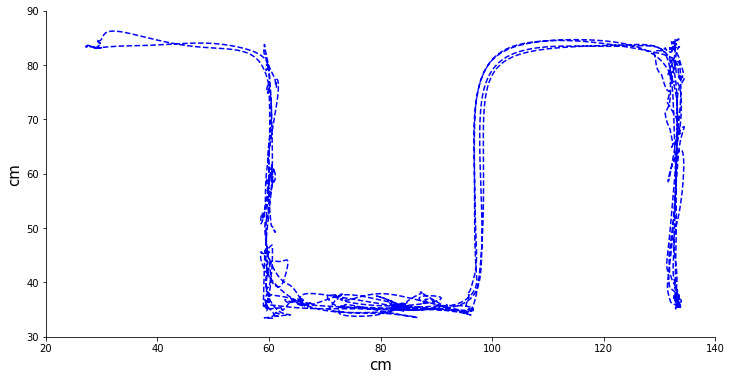

In [133]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

rats = '_pre'
print(rats)
erfdn = np.load('Rats/Rats_ephy'+rats+'.npy')[[1]];
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))
fig.set_figheight(6); fig.set_figwidth(12)
gs  = GridSpec(2 , 4);

rr = 0

for rfdn in erfdn:
    
    epn       = np.load(rfdn+'tracking'+'/epn_ephy'+rats+'.npy')[[1]]

    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)

    spd_f_ac = np.empty((0, T2+T_pre))
    n_acc_total = 0
    kk = 0
    lag_m       = np.load(rfdn+'tracking/lag_m.npy')
    idx_acc_f_T = np.load(rfdn+'tracking/idx_acc_f_T.npy')
    for k in epn:
        ax_idx = gs[0:2,0:4]; ax = fig.add_subplot(ax_idx);
        ax.set_title('')
        
        fdn = rfdn + k + '/'
        pos_Y = np.load(fdn+'tracking/'+'pos_Y_f.npy')
        pos_X = np.load(fdn+'tracking/'+'pos_X_f.npy')
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 15
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')

        ax.plot(pos_X, pos_Y, '--b', lw= 1.5)
        ax.set_xlim([20,140]);ax.set_ylim([30,90])
        ax.set_xlabel('cm', fontsize=15);ax.set_ylabel('cm', fontsize=15)
        ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)


        kk += 1
    print(n_acc_total)
    rr += 1

plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/tracking_example.svg')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/tracking_example.eps')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/tracking_example.png')

_pre
Outlaw 1
14


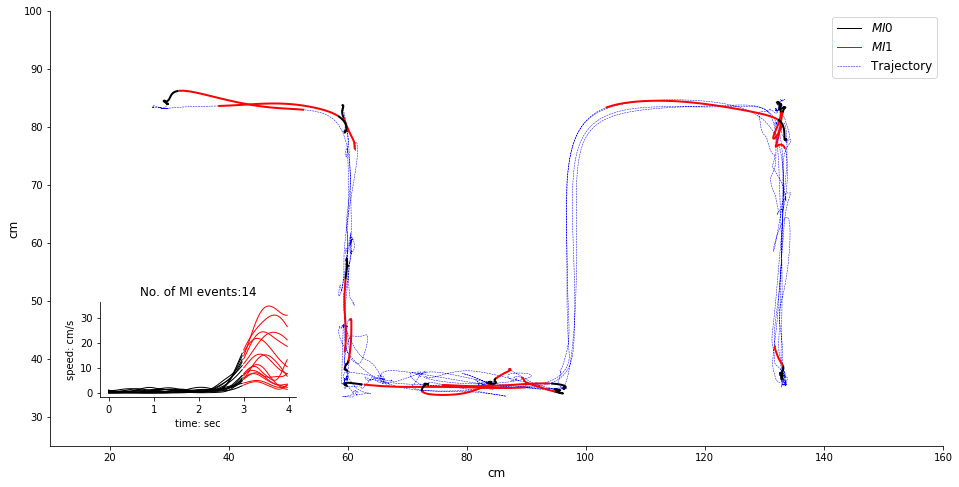

In [126]:
# rats = ''

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

rats = '_pre'
print(rats)
erfdn = np.load('Rats/Rats_ephy'+rats+'.npy')[[1]];
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))
fig.set_figheight(8); fig.set_figwidth(16)
gs  = GridSpec(2 , 4);

rr = 0

for rfdn in erfdn:
    
    epn       = np.load(rfdn+'tracking'+'/epn_ephy'+rats+'.npy')[[1]]

    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)

    spd_f_ac = np.empty((0, T2+T_pre))
    n_acc_total = 0
    kk = 0
    lag_m       = np.load(rfdn+'tracking/lag_m.npy')
    idx_acc_f_T = np.load(rfdn+'tracking/idx_acc_f_T.npy')
    for k in epn:
        ax_idx = gs[0:2,0:4]; ax = fig.add_subplot(ax_idx);
#         ax_idx = gs[0,  2]; ax2 = fig.add_subplot(ax_idx);
        ax2 = inset_axes(ax, width="55%", height="55%",
#                   bbox_to_anchor=(30, 30, 10, 10),
                    bbox_to_anchor=(.05, .1, .4, .4),
                   bbox_transform=ax.transAxes,
                            loc=3)
        
        fdn = rfdn + k + '/'
        pos_Y = np.load(fdn+'tracking/'+'pos_Y_f.npy')
        pos_X = np.load(fdn+'tracking/'+'pos_X_f.npy')
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 15
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')

        ax.plot(pos_X, pos_Y, '--b', lw= 0.5)
        ax.set_xlim([10,160]);ax.set_ylim([25,100])
        ax.set_xlabel('cm', fontsize=12);ax.set_ylabel('cm', fontsize=12)
        ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
#         ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
#         T_ts = len(ts_f[idx_clean])/fps/60

        idx_acc_f   = np.load(fdn+'tracking/idx_acc_f.npy');
        T_acc_f     = np.load(fdn+'tracking/T_acc_f.npy');
        idx_acc_f_k = np.load(fdn+'tracking/idx_acc_f_k.npy');
        n_acc = len(idx_acc_f)
        if n_acc>0:
            lag   = lag_m[idx_acc_f_k];
            idx_acc_f_T_k = idx_acc_f_T[idx_acc_f_k];
            lag       = lag[idx_acc_f_T_k]
            T_acc_f   = T_acc_f[idx_acc_f_T_k]
            idx_acc_f = idx_acc_f[idx_acc_f_T_k]
            n_acc = len(idx_acc_f)
            n_acc_total = n_acc_total+n_acc
            if n_acc>0:
                
                idx_acc_f = idx_acc_f+T_acc_f-lag
                
                for i in np.arange(len(idx_acc_f)):
                    t_ref = idx_acc_f[i]
                    idx_t_spec = np.arange(t_ref-T_pre,t_ref+T1).astype('int')
                    ax.plot(pos_X[idx_t_spec], pos_Y[idx_t_spec], 'k', lw=2)
                    ax2.plot(t[0:T_pre+T1], spd_f[idx_t_spec], 'k', lw=1)
                    
                    idx_t_spec = np.arange(t_ref+T1,t_ref+T2).astype('int')
                    ax.plot(pos_X[idx_t_spec], pos_Y[idx_t_spec], 'r', lw=2)
                    ax2.plot(t[T1:T2],      spd_f[idx_t_spec], 'r', lw=1)
                ax2.set_xlabel('time: sec');ax2.set_ylabel('speed: cm/s')
                ax2.spines['right'].set_visible(False); ax2.spines['top'].set_visible(False)
                ax2.set_title('No. of MI events:'+str(n_acc_total))

        kk += 1
    print(n_acc_total)
    rr += 1


preacc = Line2D([0], [0], color='k', ls = '-', lw = 1, label=r'$MI0$')
acc    = Line2D([0], [0], color='r', ls = '-', lw = 1, label=r'$MI1$')
track  = Line2D([0], [0], color='b', ls = '--',lw = 0.5 , label='Trajectory')
# intact = Patch(facecolor='red',label='intact')
# lesion = Patch(facecolor='blue',label='lesion')

ax.legend(handles=[preacc, acc, track], loc='upper right', fontsize = 12)
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_session_behavior_example.svg')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_session_behavior_example.eps')
plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_session_behavior_example.png')

_post
Outlaw 1


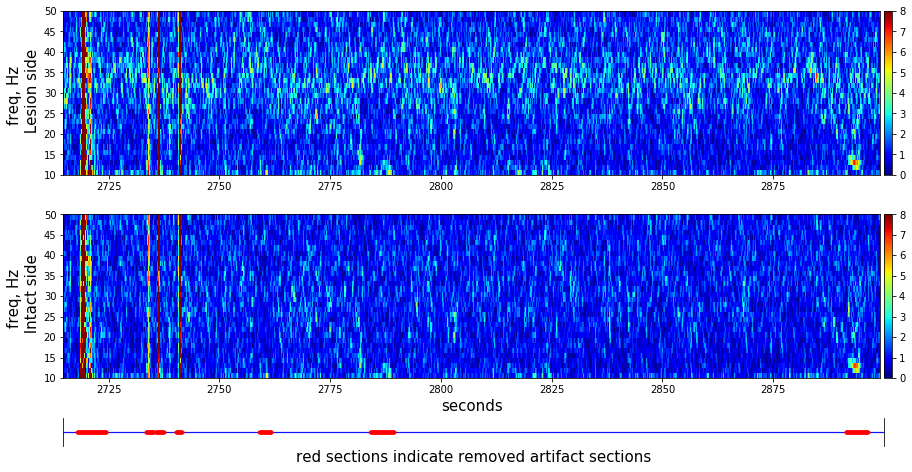

In [22]:
rats = '_post'
# rats = '_pre'
print(rats)
erfdn = np.load('Rats/Rats_ephy'+rats+'.npy')[[1]];
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))
fig.set_figheight(8); fig.set_figwidth(15)
gs  = GridSpec(13 , 100);

rr = 0
n_acc_total_r = 0
for rfdn in erfdn:
    
    epn       = np.load(rfdn+'tracking'+'/epn_ephy'+rats+'.npy')[[21]]
    slope     = np.load(rfdn+'tracking'+'/slope_epn_ephy'+rats+'.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_ephy'+rats+'.npy')

    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)
    
    idx_k   = np.zeros((n_k,))>1
    
    Y_acc_l = np.zeros((l_fb, T2+T_pre));
    Y_acc_i = np.zeros((l_fb, T2+T_pre));
    y_acc_i_all = np.zeros((l_fb, ));
    
    Y_acc_l_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_h = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_h = np.empty((0, T2+T_pre))
    spd_f_ac = np.empty((0, T2+T_pre))
    n_acc_total = 0
    kk = 0
    lag_m       = np.load(rfdn+'tracking/lag_m.npy')
    idx_acc_f_T = np.load(rfdn+'tracking/idx_acc_f_T.npy')
    for k in epn:
        fdn = rfdn + k + '/'
#         spd_f   = np.load(fdn+'tracking/'+'spd_f.npy');
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 10
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean     = np.logical_and(idx_clean_f, idx_clean_fft)
        
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        T_ts = len(ts_f[idx_clean])/fps/60

        i_ref = 0;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
#         Y_f_fit_l = Y_f[:,idx_band]
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_l = (Y_f/y_fit)[:,idx_band]


        i_ref = 1;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
#         Y_f_fit_i = Y_f[:,idx_band]
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_i = (Y_f/y_fit)[:,idx_band]


        kk += 1

        ax_idx = gs[0:5,0:99]; ax = fig.add_subplot(ax_idx);
        im = ax.pcolormesh(ts_f, f_band, Y_f_fit_l.T, 
                                   vmin = 0,
                                   vmax = 8,
                           cmap=cm.jet);
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="1%", pad=0.05)
        fig.colorbar(im, cax=cax);

    

        ax_idx = gs[6:11,0:99]; ax = fig.add_subplot(ax_idx);
        im = ax.pcolormesh(ts_f, f_band, Y_f_fit_i.T, 
                                   vmin = 0,
                                   vmax = 8,
                           cmap=cm.jet);

        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="1%", pad=0.05)
        fig.colorbar(im, cax=cax);
    rr += 1
    

ax_idx = gs[0:5,0:99]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('freq, Hz \n Lesion side', fontsize = 15)
ax_idx = gs[6:11,0:99]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('freq, Hz \n Intact side', fontsize = 15)
ax.set_xlabel('seconds',  fontsize = 15)

ax_idx = gs[12,0:98]; ax = fig.add_subplot(ax_idx);
mk = np.ones((l_t,))
idx_clean_not = np.logical_not(idx_clean)
ax.plot(ts_f[idx_clean],    mk[idx_clean],'b.', ms =0.2)
ax.plot(ts_f[idx_clean_not],mk[idx_clean_not],'r.', ms = 5)

# ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([]);
ax.set_xticks([]);
ax.set_xlim([ts_f[0],ts_f[-1]])
ax.set_xlabel('red sections indicate removed artifact sections',  fontsize = 15)



plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_session_spectrogram_z.png')
# plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_session_spectrogram.eps')
# plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_session_spectrogram.svg')

_post
Outlaw 1


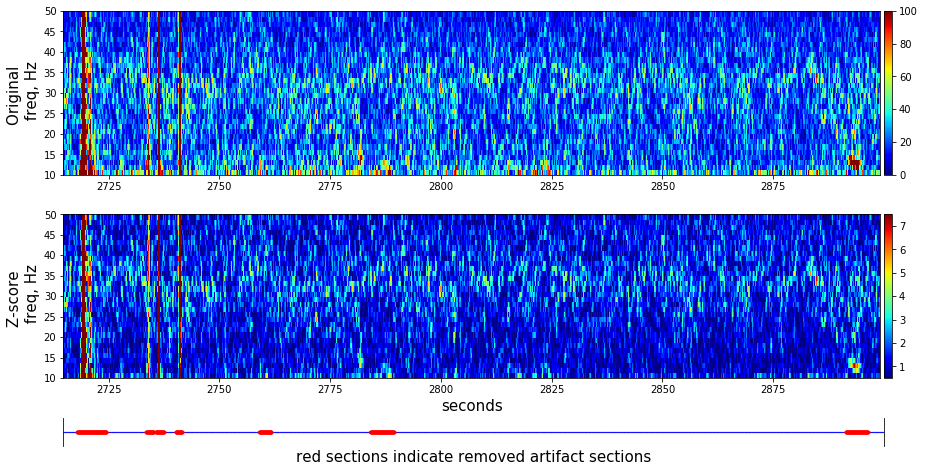

In [29]:
rats = '_post'
# rats = '_pre'
print(rats)
erfdn = np.load('Rats/Rats_ephy'+rats+'.npy')[[1]];
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))
fig.set_figheight(8); fig.set_figwidth(15)
gs  = GridSpec(13 , 100);

rr = 0
n_acc_total_r = 0
for rfdn in erfdn:
    
    epn       = np.load(rfdn+'tracking'+'/epn_ephy'+rats+'.npy')[[21]]
    slope     = np.load(rfdn+'tracking'+'/slope_epn_ephy'+rats+'.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_ephy'+rats+'.npy')

    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)
    
    idx_k   = np.zeros((n_k,))>1
    
    Y_acc_l = np.zeros((l_fb, T2+T_pre));
    Y_acc_i = np.zeros((l_fb, T2+T_pre));
    y_acc_i_all = np.zeros((l_fb, ));
    
    Y_acc_l_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_h = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_h = np.empty((0, T2+T_pre))
    spd_f_ac = np.empty((0, T2+T_pre))
    n_acc_total = 0
    kk = 0
    lag_m       = np.load(rfdn+'tracking/lag_m.npy')
    idx_acc_f_T = np.load(rfdn+'tracking/idx_acc_f_T.npy')
    for k in epn:
        fdn = rfdn + k + '/'
#         spd_f   = np.load(fdn+'tracking/'+'spd_f.npy');
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 10
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean     = np.logical_and(idx_clean_f, idx_clean_fft)
        
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        T_ts = len(ts_f[idx_clean])/fps/60

        i_ref = 0;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy')
        Y_f_fit_l = Y_f[:,idx_band]
        
    
        ax_idx = gs[0:5,0:99]; ax = fig.add_subplot(ax_idx);
        im = ax.pcolormesh(ts_f, f_band, Y_f_fit_l.T, 
                                   vmin = 0,
                                   vmax = 100,
                           cmap=cm.jet);
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="1%", pad=0.05)
        fig.colorbar(im, cax=cax);


        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_l = (Y_f/y_fit)[:,idx_band]

        ax_idx = gs[6:11,0:99]; ax = fig.add_subplot(ax_idx);
        im = ax.pcolormesh(ts_f, f_band, Y_f_fit_l.T, 
                                   vmin = 0.5,
                                   vmax = 7.5,
                           cmap=cm.jet);

        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="1%", pad=0.05)
        fig.colorbar(im, cax=cax);
        
        kk += 1
    rr += 1
    

ax_idx = gs[0:5,0:99]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('Original \n freq, Hz', fontsize = 15)
ax_idx = gs[6:11,0:99]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('Z-score \n freq, Hz', fontsize = 15)
ax.set_xlabel('seconds',  fontsize = 15)

ax_idx = gs[12,0:98]; ax = fig.add_subplot(ax_idx);
mk = np.ones((l_t,))
idx_clean_not = np.logical_not(idx_clean)
ax.plot(ts_f[idx_clean],    mk[idx_clean],'b.', ms =0.2)
ax.plot(ts_f[idx_clean_not],mk[idx_clean_not],'r.', ms = 5)

# ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([]);
ax.set_xticks([]);
ax.set_xlim([ts_f[0],ts_f[-1]])
ax.set_xlabel('red sections indicate removed artifact sections',  fontsize = 15)



plt.savefig('thesis/rice-thesis-latex_ziyingc/Figures/single_session_spectrogram_compare.png')


In [40]:
# rats = '_post'
rats = '_pre'
print(rats)
erfdn = np.load('Rats/Rats_ephy'+rats+'.npy')[[1]];
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))
fig.set_figheight(8); fig.set_figwidth(n_r*5)
gs  = GridSpec(2 , n_r);

rr = 0
n_acc_total_r = 0
for rfdn in erfdn:
    
    epn       = np.load(rfdn+'tracking'+'/epn_ephy'+rats+'.npy')[0:3]
    slope     = np.load(rfdn+'tracking'+'/slope_epn_ephy'+rats+'.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_ephy'+rats+'.npy')

    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)
    
    idx_k   = np.zeros((n_k,))>1
    
    Y_acc_l = np.zeros((l_fb, T2+T_pre));
    Y_acc_i = np.zeros((l_fb, T2+T_pre));
    y_acc_i_all = np.zeros((l_fb, ));
    Y_acc_l_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_l_m_bf_h = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_b = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_l = np.empty((0, T2+T_pre))
    Y_acc_i_m_bf_h = np.empty((0, T2+T_pre))
    
    spd_f_ac = np.empty((0, T2+T_pre))
    n_acc_total = 0
    kk = 0
    lag_m       = np.load(rfdn+'tracking/lag_m.npy')
    idx_acc_f_T = np.load(rfdn+'tracking/idx_acc_f_T.npy')
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 10
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean     = np.logical_and(idx_clean_f, idx_clean_fft)
        ts   = np.load(fdn+'tracking/'+'time_frame.npy')
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        T_ts = len(ts_f[idx_clean])/fps/60

        idx_acc_f   = np.load(fdn+'tracking/idx_acc_f.npy');
        T_acc_f   = np.load(fdn+'tracking/T_acc_f.npy');
        idx_acc_f_k = np.load(fdn+'tracking/idx_acc_f_k.npy');
        
        n_acc = len(idx_acc_f)
        if n_acc>0:
            lag   = lag_m[idx_acc_f_k];
            idx_acc_f_T_k = idx_acc_f_T[idx_acc_f_k];
            lag       = lag[idx_acc_f_T_k]
            T_acc_f   = T_acc_f[idx_acc_f_T_k]
            idx_acc_f = idx_acc_f[idx_acc_f_T_k]
            n_acc = len(idx_acc_f)
            n_acc_total = n_acc_total+n_acc
            if n_acc>0:
                idx_acc_f = idx_acc_f+T_acc_f-lag
                for i in np.arange(len(idx_acc_f)):
                    t_ref = int(idx_acc_f[i])
                    tl = ts_f[t_ref]-ts[0]
                    subprocess.call(['ffmpeg', '-i', rfdn+'videos/'+k + '.1.mp4', '-ss', str(tl), '-t', '00:00:04', 
                    '-async', '1', '-strict', '-2', rfdn+'videos/'+k + '.'+str(tl)+'.mp4'])
                    print(ts_f[t_ref], ts_f[0], ts[0], rfdn,k)

        kk += 1
    rr += 1
tl = ts_f[t_ref]-ts[0]

_pre
Outlaw 3
1996.54396667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2018.07996667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2024.47996667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2032.28796667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2107.74396667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2144.09596667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2168.70396667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2192.38396667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2217.40796667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2223.48796667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2269.82396667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal20190524_140215
2292.38396667 1971.35996667 1970.91196667 Rats/Rat_Outlaw/ myAnimal201905

<Figure size 360x576 with 0 Axes>

_post
Outlaw 1
2421.27996667 2331.07196667 2330.62396667 myAnimal20190530_104202
Drifter 1
1842.94396667 1822.36796667 1821.85596667 myAnimal20190404_151349
Lenny 1
103.615966667 97.4719666667 97.0559666667 myAnimal20190104_164305_track

ffmpeg -i movie.mp4 -ss 00:00:03 -t 00:00:08 -async 1 -strict -2 cut.mp4
ffmpeg -ss 5.32 -i input.mp4 -c:v libx264 -c:a aac out.mp4


'ffmpeg', '-i', rfdn+'videos/'+k + '.1.mp4', '-ss', '90.656', '-t', '00:00:04', 
'-async', '1', '-strict', '-2', rfdn+'videos/'+k + '.cut.mp4'

In [37]:
import subprocess
rfdn = 'Rats/Rat_Outlaw/'
k    = 'myAnimal20190530_104202'

fn = rfdn + k + '/' + k


0